## Experiment 3: Realworld data & Multiple kernels & projections

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import torch
from gp import *
import pandas as pd
import numpy as np

if torch.cuda.is_available():
    device = torch.device("cuda")
#elif torch.backends.mps.is_available():
#    device = torch.device("mps")  # Apple Silicon
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: cpu


### Sunspots data

In [2]:
# Load CSV (skip comment lines if they exist)
df = pd.read_csv("data/SN_m_tot_V2.0.csv", sep=";", comment="#", header=None)

# According to the spec:
# Col 0 = Year, Col 1 = Month, Col 2 = Decimal year, Col 3 = Monthly mean
years = df[0].to_numpy()
months = df[1].to_numpy()
decimal_date = df[2].to_numpy()
sunspot_mean = df[3].to_numpy()

# Use fractional year directly as "date"
date_array = decimal_date  

number of training points: 3320


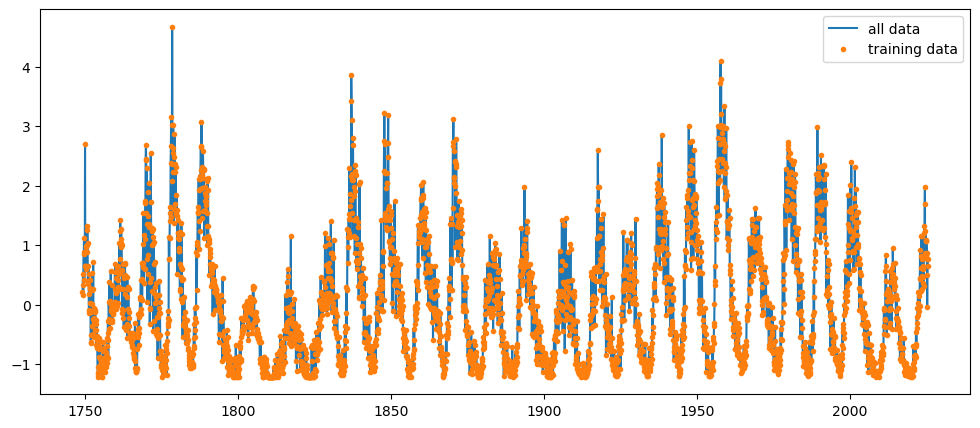

In [3]:
X_data = torch.from_numpy(date_array).unsqueeze(1)
y_data = torch.from_numpy(sunspot_mean).unsqueeze(1) 
# normalise
y_data = y_data - torch.mean(y_data)
y_std = torch.std(y_data)
if y_std > 0:     # guard against division by zero
    y_data = y_data / y_std

idx = torch.randperm(y_data.shape[0])[:]
# subset of the data
X_train = X_data[idx]
y_train = y_data[idx]

#X_train = X_data
#y_train = y_data

plt.figure(figsize=(12, 5))
plt.plot(X_data,y_data, label = 'all data')
plt.plot(X_train,y_train, '.', label = 'training data')
plt.legend()
print(f'number of training points: {y_train.shape[0]}')

In [4]:
## training preamble

kernels = ['SE', 'Laplace', 'RQ', 'LocPer']
methods = ['proj-sphere', 'proj-localised', 'proj-onehot', 'proj-mix'] #projections


M_elbo = 100
M_proj = 100

times_nll = []
out_nll = []





In [5]:
#training setting
methods = ['proj-sphere'] #projections

times_vfe = []
out_vfe = []
times_proj = []
out_proj = []

# for 1000 points
n_steps_1 = 2001
lr_1 = 0.5
tol = 1e-3
optimizer_1 = 'Adam'

# for 2000 points
n_steps_1 = 2001
lr_1 = 0.01
tol = 1e-3
optimizer_1 = 'Adam'

# for all 3300 points
n_steps_1 = 2001
lr_1 = 0.01
tol = 1e-3
optimizer_1 = 'Adam'

In [6]:
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X_train = X_train.to(device)
X_train = X_train.to(device)


In [7]:
X_train.device

device(type='cpu')

In [ ]:
## training routine



print('starting training ....')
for k in kernels:
    print(f'kernel = {k}')
    
    ##### Vanilla GP (NLL) #####
    print('NLL training ...')
    
    gp_nll = GP(X_train, y_train, kernel = k)
    out = gp_nll.train_step(obj = 'nll', opt_name=optimizer_1, lr=lr_1, n_steps=n_steps_1, tol=tol, verbose = True)

    
    times_nll.append(out["time"])     # save elapsed time
    out_nll.append(out["nll"])
    
    
    ##### SparseGP (ELBO) ##### 
    
    gp_elbo = GP(X_train, y_train, kernel = k, M=M_elbo, method = 'VFE')
    out = gp_elbo.train_step(obj = 'elbo', opt_name=optimizer_1, lr=lr_1, n_steps=n_steps_1, tol=tol, verbose = True)

    times_vfe.append(out["time"])     # save elapsed time
    out_vfe.append(out["nll"])
    
    for m in methods:
        print(f'projection method = {m}')
    
        ##### ProjGP ##### 
        gp_proj = GP(X_train, y_train, kernel = k, M=M_proj, method = m)
        out = gp_proj.train_step(obj = 'proj', opt_name=optimizer_1, lr=lr_1, n_steps=n_steps_1, tol=tol, verbose = True)        

        times_proj.append(out["time"])     # save elapsed time
        out_proj.append(out["nll"])
        
print('Training complete')        

starting training ....
kernel = SE
NLL training ...
Using device: cpu
Optimising nll using Adam
norma: tensor([1.0000, 1.0000, 0.6931], dtype=torch.float64, grad_fn=<CatBackward0>)
Epoch 0: loss = 3092.9515


In [ ]:
r_nll = np.array([a for a in out_nll])  # shape (4,)
r_elbo = np.array([a for a in out_vfe])  # shape (4,)
r_proj = np.array([a for a in out_proj])  # shape (4,)

print(r_nll)
print(r_elbo)
print(r_proj) 

In [ ]:
def make_table_combined(kernels, nll_vals, elbo_vals, proj_vals, time_nll, time_elbo, time_proj, caption, label):
    """
    Build one LaTeX table with multicolumns and horizontal rules.
    - First column: kernel name
    - Then: ML (NLL, Time), ELBO (NLL, Time), PL (NLL, Time)
    """

    tab = "\\begin{table}[ht]\n\\centering\n"
    tab += "\\scriptsize\n"
    tab += "\\begin{tabular}{lcccccc}\n"
    tab += "\\toprule\n"
    # Header with multicolumns
    tab += "Kernel & \\multicolumn{2}{c}{ML} & \\multicolumn{2}{c}{ELBO} & \\multicolumn{2}{c}{PL} \\\\\n"
    tab += "\\cmidrule(lr){2-3} \\cmidrule(lr){4-5} \\cmidrule(lr){6-7}\n"
    tab += " & NLL & Time & NLL & Time & NLL & Time \\\\\n"
    tab += "\\midrule\n"

    for i, k in enumerate(kernels):
        row = (
            f"{k} & {nll_vals[i]:.3f} & {time_nll[i]:.2f}"
            f" & {elbo_vals[i]:.3f} & {time_elbo[i]:.2f}"
            f" & {proj_vals[i]:.3f} & {time_proj[i]:.2f}"
        )
        tab += row + " \\\\\n"

    tab += "\\bottomrule\n\\end{tabular}\n"
    tab += f"\\caption{{{caption}}}\n"
    tab += f"\\label{{{label}}}\n"
    tab += "\\end{table}\n"
    return tab


print(make_table_combined(kernels, r_nll, r_elbo, r_proj,  times_nll, times_vfe, times_proj, "Sunspots: Performance and running time", "tab:sunspots"))


### EEG Data

In [ ]:
import mne
 
# read data
raw = mne.io.read_raw_edf("data/eeg27.edf", preload=True)
data, times = raw.get_data(return_times=True)
channel_names = raw.ch_names
df = pd.DataFrame(data.T, columns=channel_names)  
df["Time"] = times  
 
# random indices
idx = np.random.choice(400000, size=4000)
idx.sort()
 
# use random channel and scale it
X = df['Time'].to_numpy()[idx]
y = 1e5*df["EEG F3-Ref"].to_numpy()[idx]


In [ ]:
X_data = torch.from_numpy(X).unsqueeze(1)
y_data = torch.from_numpy(y).unsqueeze(1) 
y_data -= torch.mean(y_data)
y_std = torch.std(y_data)
if y_std > 0:     # guard against division by zero
    y_data = y_data / y_std

idx = torch.randperm(y_data.shape[0])[:2000]
# subset of the data
X_train = X_data[idx]
y_train = y_data[idx]

#all data
#X_train = X_data
#y_train = y_data


plt.figure(figsize=(12, 5))
plt.plot(X_train[:],y_train[:], '.', label='training data')
#plt.plot(X_data,y_data, label='all data')
print(f'number of datapoints: {y.shape[0]}')


In [ ]:
## training preamble

kernels = ['SE', 'Laplace', 'RQ', 'LocPer']
methods = ['proj-sphere'] #projections
M_elbo = 100
M_proj = 100

times_nll = []
out_nll = []
times_vfe = []
out_vfe = []
times_proj = []
out_proj = []

#training setting
# for all 3300 points
n_steps = 2001
lr = 0.01
tol = 1e-3
optimizer = 'Adam'

In [ ]:
## training routine



print('starting training ....')
for k in kernels:
    print(f'kernel = {k}')
    
    ##### Vanilla GP (NLL) #####
    print('NLL training ...')
    
    gp_nll = GP(X_train, y_train, kernel = k)
    out = gp_nll.train_step(obj = 'nll', opt_name=optimizer, lr=lr, n_steps=n_steps, tol=tol, verbose = True)
    
    times_nll.append(out["time"])     # save elapsed time
    out_nll.append(out["nll"])
    
    
    ##### SparseGP (ELBO) ##### 
    
    gp_elbo = GP(X_train, y_train, kernel = k, M=M_elbo, method = 'VFE')
    out = gp_elbo.train_step(obj = 'elbo', opt_name=optimizer, lr=lr, n_steps=n_steps, tol=tol, verbose = True)

    times_vfe.append(out["time"])     # save elapsed time
    out_vfe.append(out["nll"])
    
    for m in methods:
        print(f'projection method = {m}')
    
        ##### ProjGP ##### 
        gp_proj = GP(X_train, y_train, kernel = k, M=M_proj, method = m)
        out = gp_proj.train_step(obj = 'proj', opt_name=optimizer, lr=lr, n_steps=n_steps, tol=tol, verbose = True)        

        times_proj.append(out["time"])     # save elapsed time
        out_proj.append(out["nll"])
        
print('Training complete')        

In [ ]:
r_nll = np.array([a for a in out_nll])  # shape (4,)
r_elbo = np.array([a for a in out_vfe])  # shape (4,)
r_proj = np.array([a for a in out_proj])  # shape (4,)

print(r_nll)
print(r_elbo)
print(r_proj) 

In [ ]:
print(make_table_combined(kernels, r_nll, r_elbo, r_proj,  times_nll, times_vfe, times_proj, "2000 EEG: Performance and running time", "tab:eeg"))


In [ ]:
X_train.shape


#### 